In [44]:
from gluonts.dataset.repository import get_dataset

import matplotlib.pyplot as plt

import os
import pickle

In [45]:
NORMALIZER_NAME = "gas_t_student"
MEAN_MODEL = "gas"
DL_MODEL_LIBRARY = "gluonts"
DATASET_NAME = "fred_md"
DATASET_TYPE = "gluonts"    # gluonts or synthetic
DL_MODEL = "transformer"

multivariate = "_multivariate"   # "_multivariate" if its multivariate, empty otherwise
multivariate = ""

ROOT_FOLDER = f"RESULTS_{DATASET_NAME}_{NORMALIZER_NAME}_{MEAN_MODEL}_{DL_MODEL_LIBRARY}_{DL_MODEL}" + multivariate

Get results

In [46]:
normalizer_folder = os.path.join(ROOT_FOLDER, "normalizer")
init_params_norm_filename = os.path.join(normalizer_folder, 'init_params.json')
###
means_folder = os.path.join(normalizer_folder, 'means')
train_means_folder = os.path.join(means_folder, 'train')
test_means_folder = os.path.join(means_folder, 'test')
vars_folder = os.path.join(normalizer_folder, 'vars')
train_vars_folder = os.path.join(vars_folder, 'train')
test_vars_folder = os.path.join(vars_folder, 'test')
norm_ts_folder = os.path.join(normalizer_folder, 'normalized_ts')
train_norm_ts_folder = os.path.join(norm_ts_folder, 'train')
test_norm_ts_folder = os.path.join(norm_ts_folder, 'test')
params_folder = os.path.join(normalizer_folder, 'normalizer_params')
train_params_folder = os.path.join(params_folder, 'train')
test_params_folder = os.path.join(params_folder, 'test')

train_means = []
for i in range(len(os.listdir(train_means_folder))):
    with open(os.path.join(train_means_folder, f'ts_{i}.pkl'), 'rb') as f:
        train_means.append(pickle.load(f))
test_means = []
for i in range(len(os.listdir(test_means_folder))):
    with open(os.path.join(test_means_folder, f'ts_{i}.pkl'), 'rb') as f:
        test_means.append(pickle.load(f))
train_vars = []
for i in range(len(os.listdir(train_vars_folder))):
    with open(os.path.join(train_vars_folder, f'ts_{i}.pkl'), 'rb') as f:
        train_vars.append(pickle.load(f))
test_vars = []
for i in range(len(os.listdir(test_vars_folder))):
    with open(os.path.join(test_vars_folder, f'ts_{i}.pkl'), 'rb') as f:
        test_vars.append(pickle.load(f))
train_params = []
for i in range(len(os.listdir(train_params_folder))):
    with open(os.path.join(train_params_folder, f'ts_{i}.pkl'), 'rb') as f:
        train_params.append(pickle.load(f))
test_params = []
for i in range(len(os.listdir(test_params_folder))):
    with open(os.path.join(test_params_folder, f'ts_{i}.pkl'), 'rb') as f:
        test_params.append(pickle.load(f))
test_norm_ts = []
for i in range(len(os.listdir(test_norm_ts_folder))):
    with open(os.path.join(test_norm_ts_folder, f'ts_{i}.pkl'), 'rb') as f:
        test_norm_ts.append(pickle.load(f))

Get dataset

In [47]:
from data_manager import GluonTSDataManager

bool_multivar = False if multivariate == "" else True
data_manager = GluonTSDataManager(DATASET_NAME, bool_multivar)

prediction_length = data_manager.prediction_length
context_length = data_manager.context_length

data_manager.set_data_from_normalizer(train_means, train_vars, test_means, test_vars, train_params)
train_dataset, test_dataset = data_manager.get_gluon_dataset_for_dl_layer()

Plot stuff

[1.00000000e+00 2.93388177e-04 3.69640875e-01 2.72197909e-01
 9.99999000e-01 9.99999000e-01 0.00000000e+00 3.36036215e-05
 9.90000000e+01]


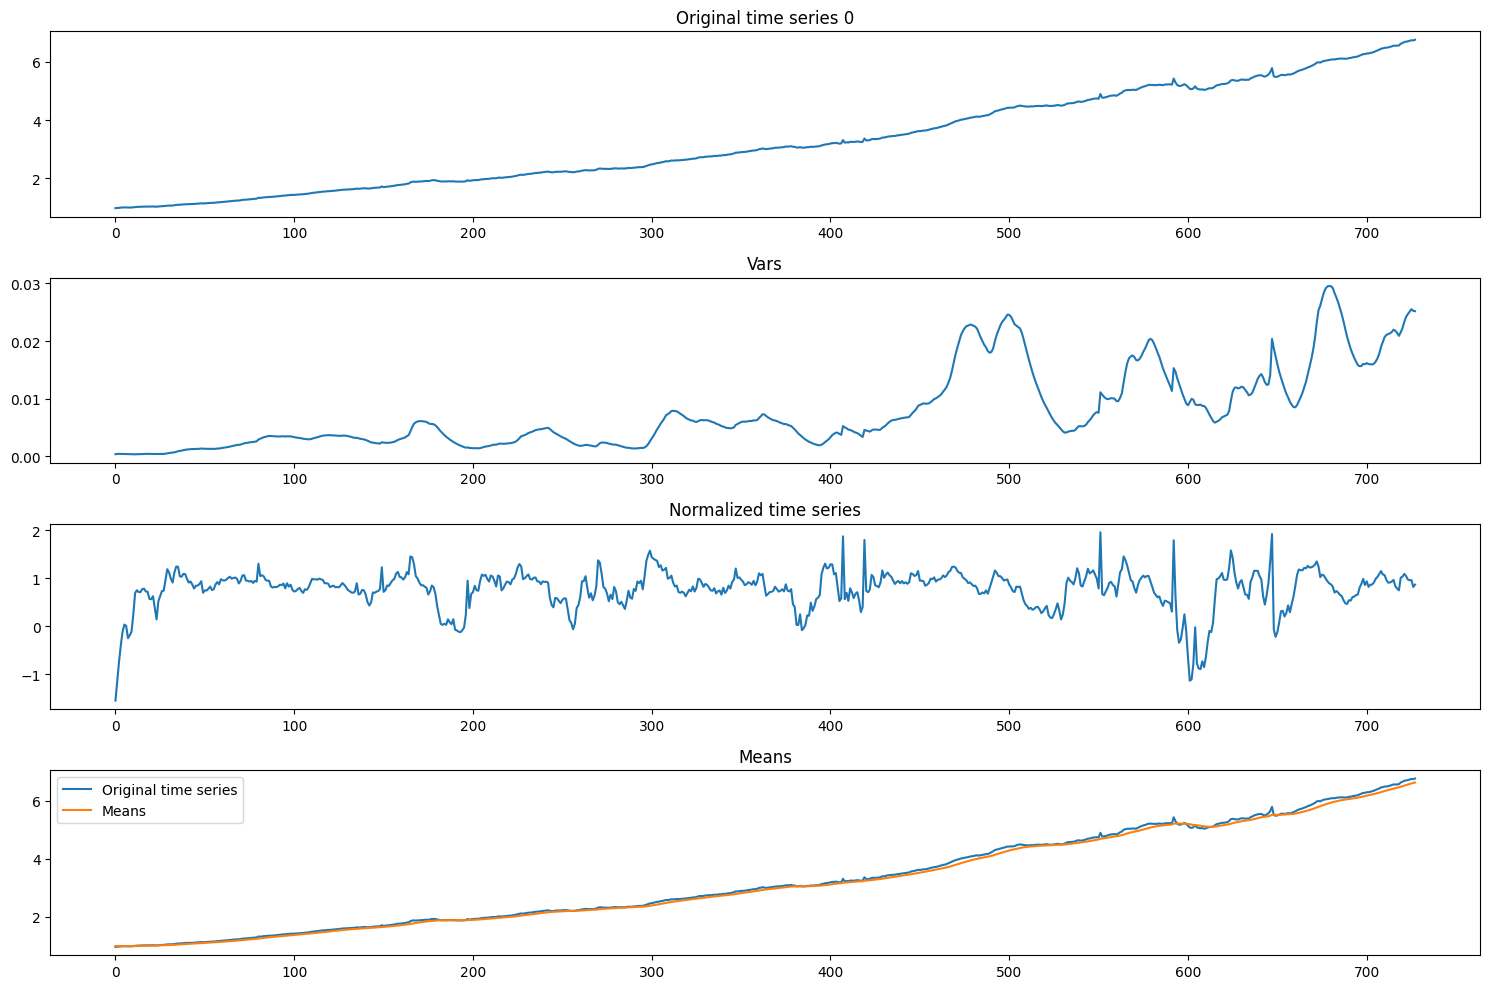

[1.00000000e+00 2.81368615e-04 9.16888779e-01 2.67476631e-01
 9.99999000e-01 9.99999000e-01 0.00000000e+00 1.05107190e-05
 9.90000000e+01]


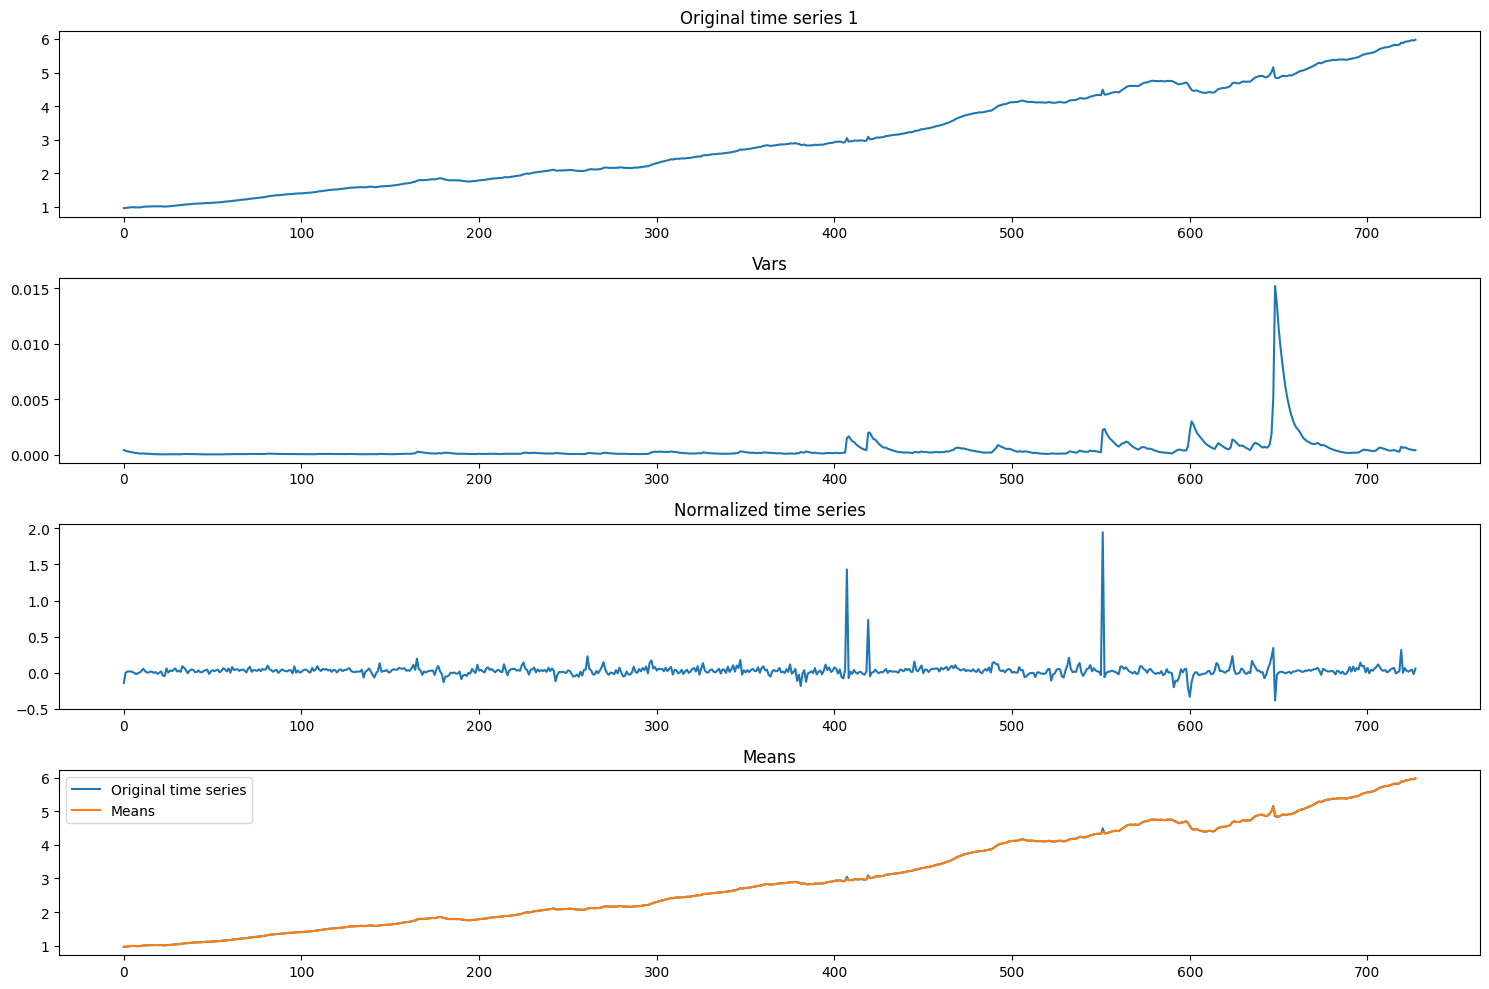

In [48]:
for ts_index in range(min(50, len(test_dataset))):

    # create a subfigure with 5 plots in each: 
    # - the original time series, 
    # - the normalized time series, 
    # - the original time series with its means,
    # - the original time series with its vars,
    # - the original time series with the predictions
    ts = test_dataset[ts_index]["target"]
    means = test_means[ts_index]
    vars = test_vars[ts_index]
    norm_ts = test_norm_ts[ts_index]
    par = train_params[ts_index]
    print(par)

    fig, axs = plt.subplots(4, 1, figsize=(15, 10))
    axs[0].plot(ts)
    axs[0].set_title(f'Original time series {ts_index}')

    axs[1].plot(vars)
    axs[1].set_title('Vars')

    axs[2].plot(norm_ts)
    axs[2].set_title('Normalized time series')

    axs[3].plot(ts)
    axs[3].plot(means)
    axs[3].set_title('Means')
    axs[3].legend(['Original time series', 'Means'])

    plt.tight_layout()
    plt.show()

Load the DL model

In [49]:
dl_folder = os.path.join(ROOT_FOLDER, "dl_model")

with open(os.path.join(dl_folder, "dl_model.pkl"), "rb") as f:
    predictor = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'RESULTS_fred_md_gas_t_student_gas_gluonts_transformer/dl_model/dl_model.pkl'

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
import json
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 107it [00:00, 429.10it/s]


{
    "MSE": 5.241422579876173,
    "abs_error": 1093.7621874809265,
    "abs_target_sum": 14529.476307153702,
    "abs_target_mean": 11.315791516474844,
    "seasonal_error": 0.4518549102172572,
    "MASE": 5.159543972534335,
    "MAPE": 0.5819747147976685,
    "sMAPE": 0.2690264088713863,
    "MSIS": 58.656251157951246,
    "QuantileLoss[0.1]": 717.2563142463564,
    "Coverage[0.1]": 0.05919003115264798,
    "QuantileLoss[0.5]": 1093.762178659439,
    "Coverage[0.5]": 0.8278816199376949,
    "QuantileLoss[0.9]": 743.9136866092681,
    "Coverage[0.9]": 0.9750778816199377,
    "RMSE": 2.28941533581746,
    "NRMSE": 0.20232038850170253,
    "ND": 0.07527884449231002,
    "wQuantileLoss[0.1]": 0.049365599907631195,
    "wQuantileLoss[0.5]": 0.07527884388516581,
    "wQuantileLoss[0.9]": 0.05120030969340556,
    "mean_absolute_QuantileLoss": 851.6440598383546,
    "mean_wQuantileLoss": 0.05861491782873419,
    "MAE_Coverage": 0.4750778816199377,
    "OWA": NaN
}


In [ ]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2018-09,0.039256,1.518448,80.043327,6.670277,0.101081,1.251838,0.019087,0.018794,0.018970,34.541998,1.563874,0.0,1.518448,0.666667,2.104652,1.0
1,None,2018-09,0.089761,2.472347,70.836349,5.903029,0.097346,2.116453,0.035120,0.033805,0.034902,38.710208,1.437986,0.0,2.472347,0.916667,2.386925,1.0
2,None,2018-09,0.028219,1.826549,79.624573,6.635381,0.098141,1.550953,0.022931,0.022597,0.022940,36.482293,1.634937,0.0,1.826549,1.000000,2.340639,1.0
3,None,2018-09,0.229571,4.132313,328.391266,27.365939,0.505327,0.681459,0.012547,0.012590,0.012584,17.210046,4.678817,0.0,4.132313,0.333333,4.222592,1.0
4,None,2018-09,0.111923,3.953160,55.636051,4.636338,0.112360,2.931915,0.070942,0.067803,0.071054,26.642601,1.065603,0.0,3.953160,1.000000,2.473060,1.0


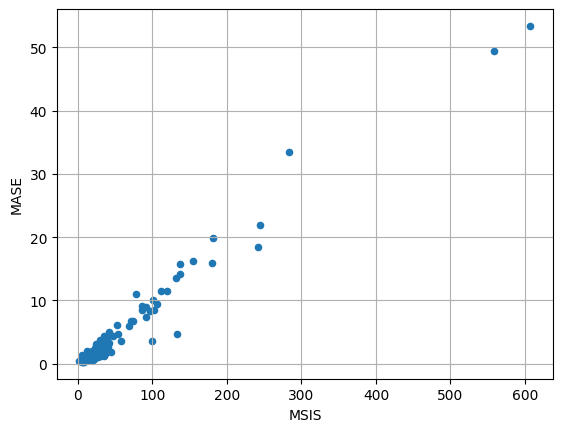

In [ ]:
import matplotlib.pyplot as plt

item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [6.4780107 6.99561   7.056094  6.6466374 6.6658483 6.627496  6.6963973
 6.7605658 6.80815   6.844096  6.840907  6.8542614]
0.5-quantile (median) of the future window:
 [6.4766765 6.981711  6.887075  6.7495418 6.6027975 6.595391  6.660727
 6.7578716 6.7606997 6.8169303 6.8701963 6.8855524]


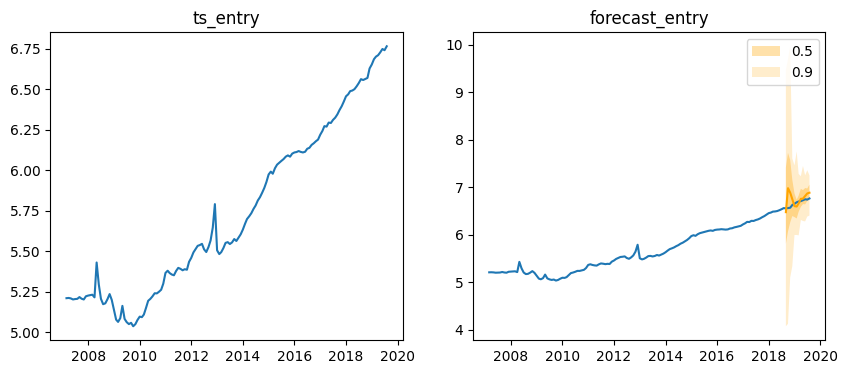

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [6.265845  6.379087  6.4189587 6.2561364 5.8369994 5.8103704 5.9280205
 6.037412  6.0593705 6.0830145 6.020892  6.1436334]
0.5-quantile (median) of the future window:
 [5.939752  6.410371  6.583968  6.253912  5.923544  5.8846374 5.9365993
 6.0066833 6.060097  6.0994577 6.0263357 6.1341853]


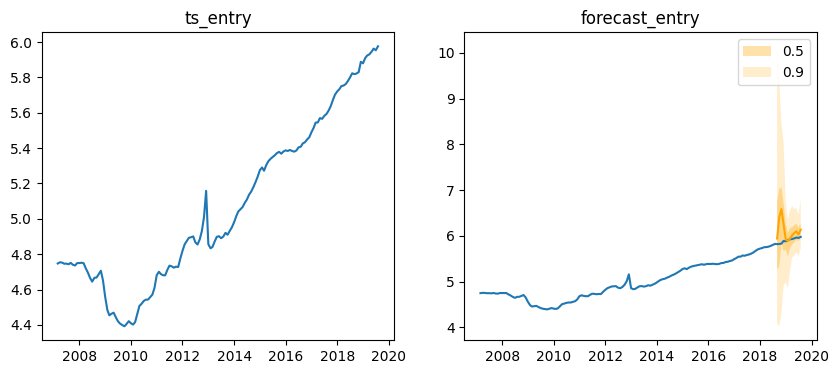

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [6.5213304 6.806689  6.915161  6.5843983 6.841878  6.611862  6.6528277
 6.820635  6.865455  6.829354  6.8450966 6.9307213]
0.5-quantile (median) of the future window:
 [6.73099   6.839571  6.9164577 6.6670046 6.771881  6.615662  6.6376133
 6.794646  6.8522463 6.7979703 6.8735023 6.9535794]


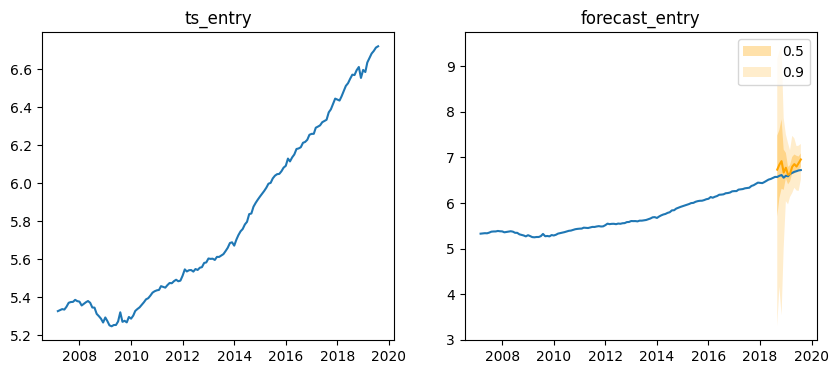

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [26.558697 27.255932 27.686712 26.944649 27.452385 27.774426 27.04548
 27.450144 27.565075 27.11896  27.55755  27.209461]
0.5-quantile (median) of the future window:
 [26.621166 27.172615 27.486753 26.996422 27.237032 27.48671  27.012337
 27.370218 27.383484 27.301973 27.602137 27.247679]


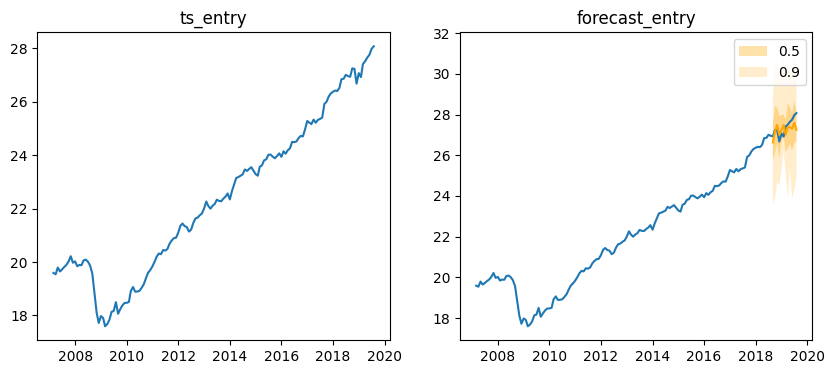

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [4.831308  5.0823956 5.4861255 4.8347163 4.9134307 4.810241  4.8748307
 4.7965755 4.8610573 4.880048  4.8083553 4.8856306]
0.5-quantile (median) of the future window:
 [5.032026  5.2991414 5.442168  5.0539756 4.956535  4.7857747 4.822125
 4.8023853 4.865547  4.835508  4.8227863 4.871238 ]


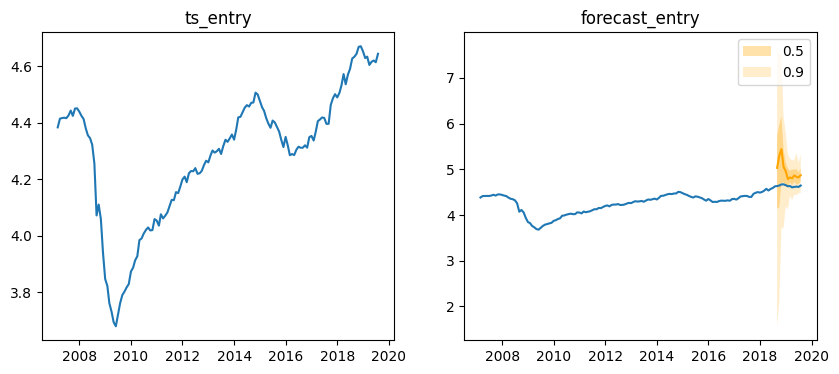

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [4.0878315 5.236601  5.097666  4.7715826 4.4941745 4.3765016 4.4111443
 4.4016695 4.4676137 4.390135  4.4175043 4.4036794]
0.5-quantile (median) of the future window:
 [4.246921  5.3666687 5.270794  4.659556  4.62375   4.399396  4.4489217
 4.4333005 4.470657  4.408929  4.426689  4.4301853]


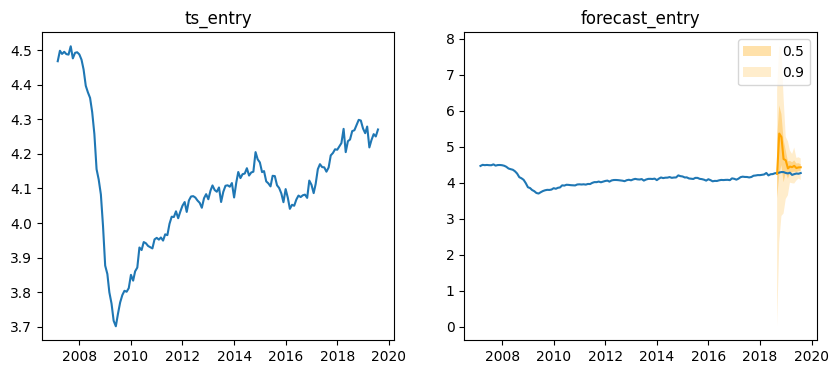

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [4.8698606 5.1389112 5.049635  4.7602434 4.7014112 4.4509664 4.608519
 4.595006  4.711577  4.6709385 4.556433  4.6409364]
0.5-quantile (median) of the future window:
 [4.731505  5.0647964 5.1469803 4.7413836 4.7077694 4.5195403 4.603383
 4.5824857 4.671873  4.6555934 4.589845  4.637634 ]


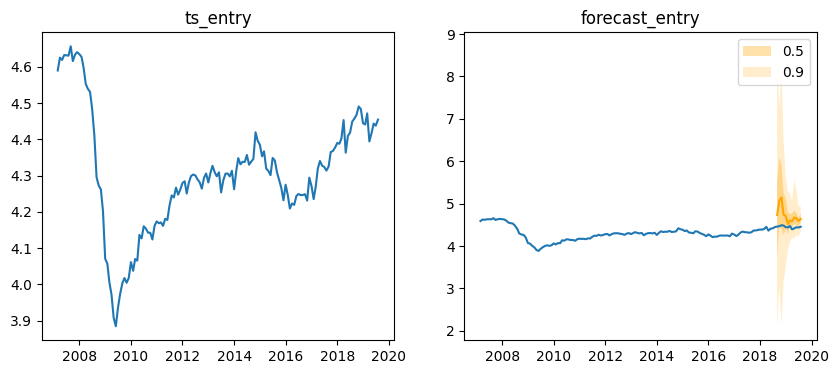

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.7074194 4.2539535 4.1737404 3.9413705 3.5728412 3.345746  3.28021
 3.2604184 3.2835352 3.299396  3.226555  3.2862937]
0.5-quantile (median) of the future window:
 [3.8547766 4.3675857 4.0805697 3.9056325 3.421236  3.313483  3.29804
 3.2633364 3.2714605 3.2542746 3.2134318 3.2798862]


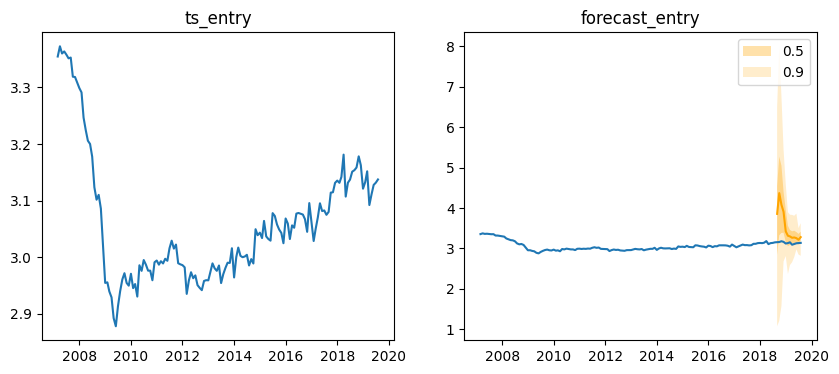

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [5.6177855 5.8792834 5.797287  5.822972  5.4088507 5.441338  5.4645586
 5.5496106 5.516407  5.502618  5.501888  5.6328063]
0.5-quantile (median) of the future window:
 [5.562997  5.5518694 5.8948293 5.792283  5.4873867 5.4163284 5.436551
 5.53355   5.5137362 5.484419  5.4944453 5.6042724]


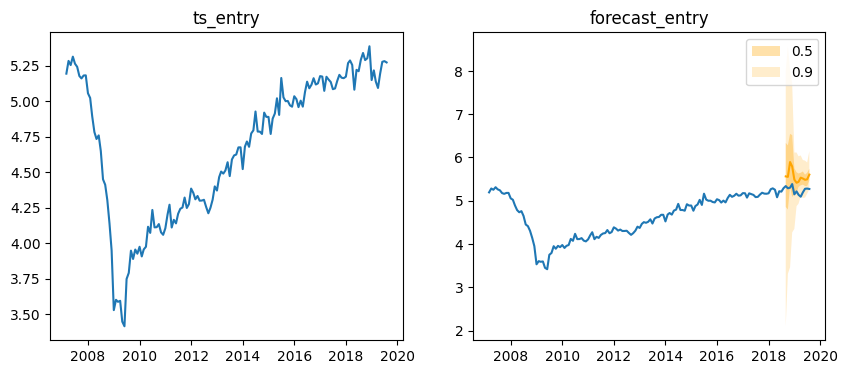

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.9407983 3.405306  3.4339237 3.4992454 3.066671  2.761881  2.7353442
 2.7252667 2.6415505 2.672055  2.7242155 2.701371 ]
0.5-quantile (median) of the future window:
 [3.0679471 3.3158965 3.3600712 3.1735847 3.109493  2.7930603 2.8155055
 2.725917  2.650899  2.6403873 2.698051  2.7283838]


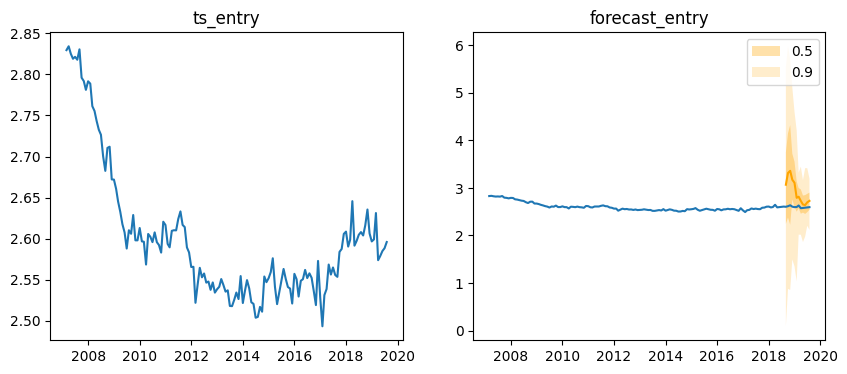

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [11.5835705 11.745111  12.108912  11.829037  11.794757  11.657834
 11.749546  11.763025  11.870897  11.866834  12.163872  12.250988 ]
0.5-quantile (median) of the future window:
 [11.623645  11.805275  12.281432  11.831124  11.737786  11.699265
 11.724268  11.817719  12.02274   12.016523  12.1344595 12.207588 ]


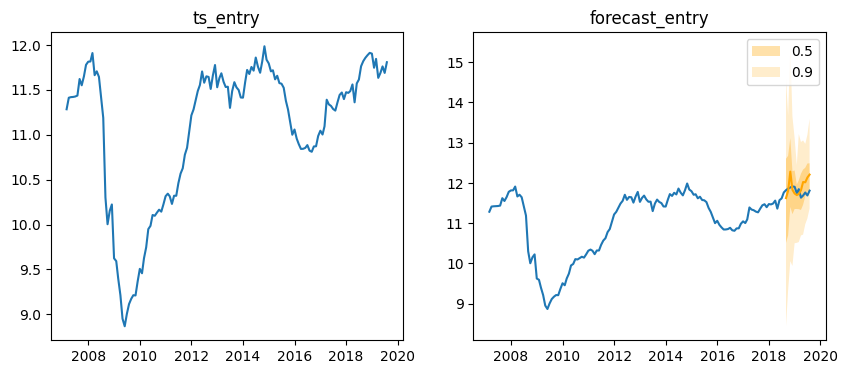

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [5.244533  5.514855  5.8728733 5.491285  5.4654446 5.272522  5.3218145
 5.4398513 5.449986  5.4632897 5.3808455 5.4486737]
0.5-quantile (median) of the future window:
 [5.1327486 5.5677195 5.753103  5.511727  5.4016714 5.277785  5.3414536
 5.4434724 5.443104  5.4350076 5.379798  5.444302 ]


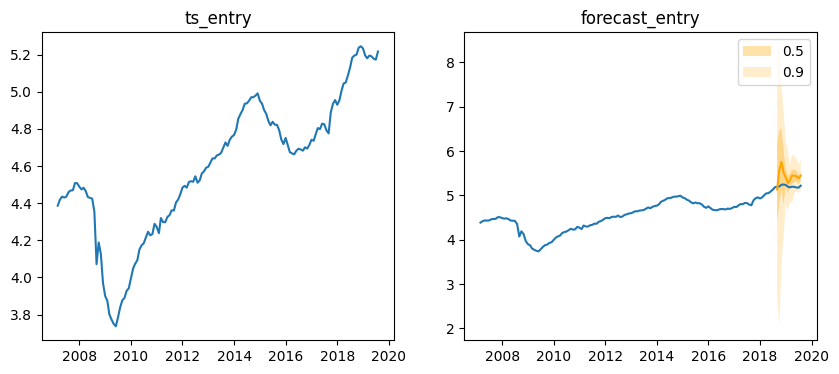

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [8.345041 8.268697 8.731884 8.368284 8.476076 8.113252 8.343064 8.436163
 8.458458 8.561644 8.660932 8.728528]
0.5-quantile (median) of the future window:
 [8.496449 8.149193 8.874532 8.353454 8.432871 8.15185  8.338206 8.432948
 8.438792 8.560667 8.683128 8.726043]


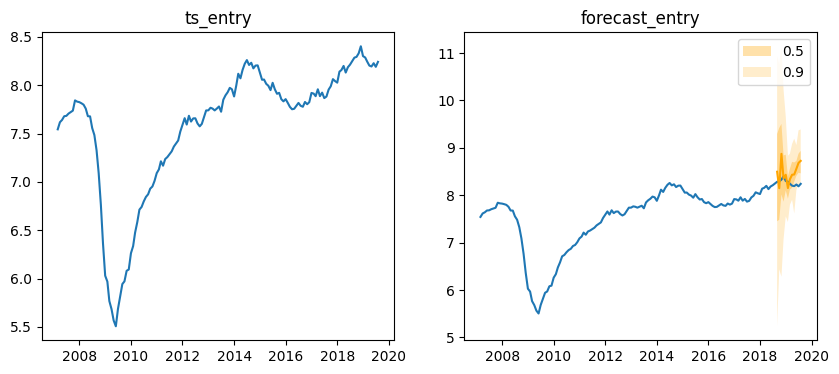

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.4482162 3.975644  4.1296043 3.5217783 3.733644  3.438284  3.3708277
 3.3160186 3.342731  3.397559  3.2915106 3.3689203]
0.5-quantile (median) of the future window:
 [3.7473378 3.9755905 3.9191513 3.5614965 3.7187421 3.344217  3.3057342
 3.311401  3.3310108 3.3078034 3.307509  3.3759806]


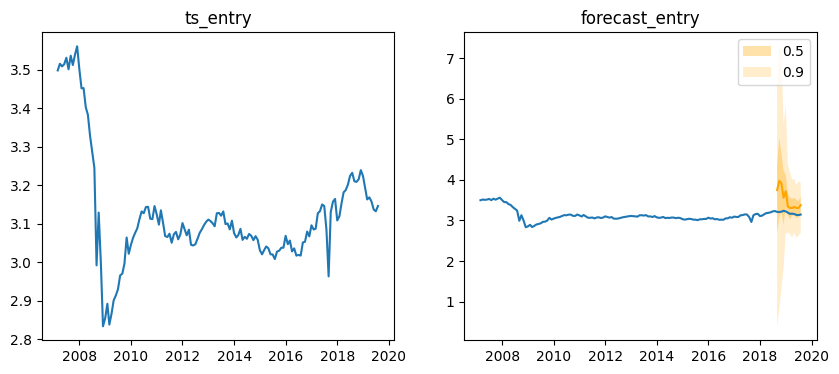

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [4.671738  5.1454115 5.462469  5.098754  5.048815  4.955859  4.9652324
 4.9738603 4.9678345 5.0023985 4.957555  5.0194454]
0.5-quantile (median) of the future window:
 [5.129822  5.2780647 5.480424  5.3380933 5.0905232 4.851792  4.9368286
 5.0262465 4.9772763 4.985188  4.9264874 4.997825 ]


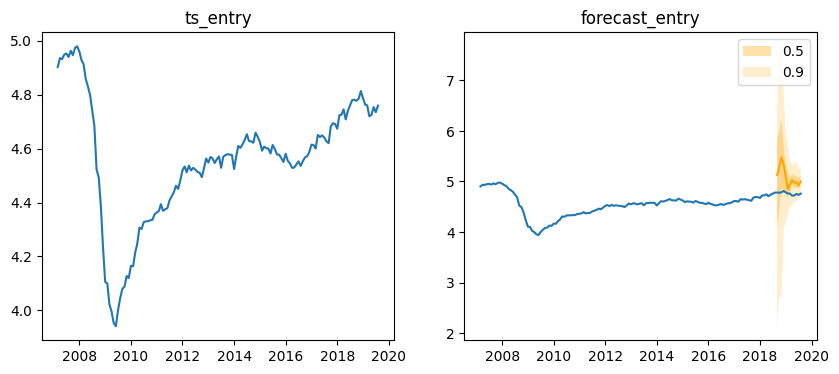

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [5.161059  5.271631  5.58611   5.380946  5.1461134 4.9873824 5.012993
 5.131986  5.0370026 5.0763893 5.080135  5.163788 ]
0.5-quantile (median) of the future window:
 [4.945172  5.3135047 5.6205363 5.3710394 5.1272974 4.954889  5.0172567
 5.108327  5.0573063 5.0882735 5.0817    5.1698174]


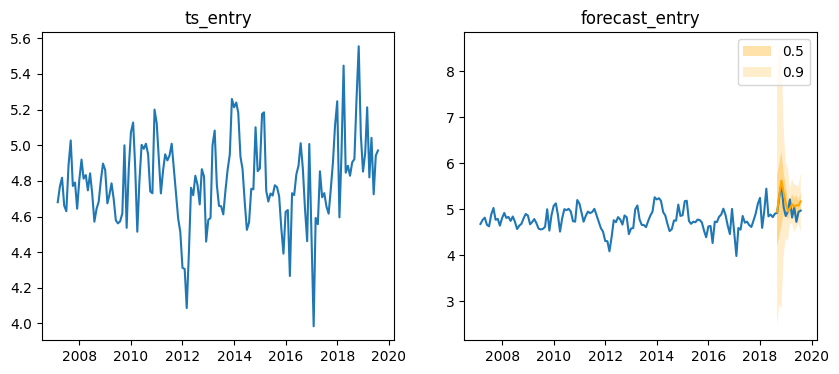

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.2390776 3.6751854 3.5690873 3.4522445 3.363403  3.1779604 2.956617
 3.0835357 3.0140455 3.1063485 2.972097  3.093568 ]
0.5-quantile (median) of the future window:
 [3.4783607 3.7265928 3.6480162 3.3931665 3.348264  3.1796684 3.018413
 3.0838876 2.9563043 3.0983334 2.952414  3.0621758]


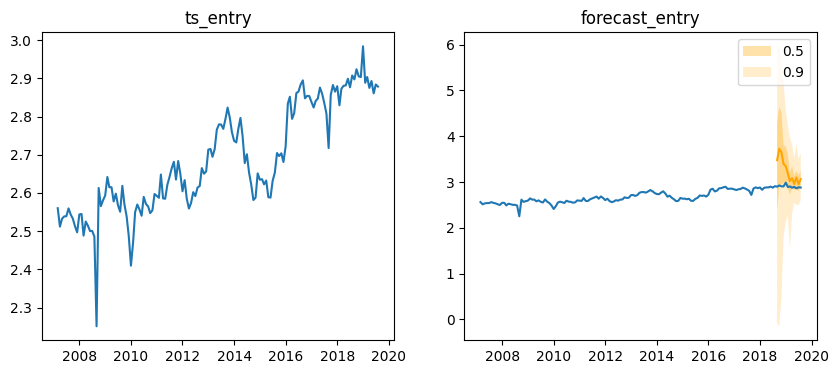

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.622226  1.6005232 2.344534  2.033731  1.5278757 1.4985144 1.2598557
 1.5155848 1.3247097 1.2412719 1.1693934 1.2946134]
0.5-quantile (median) of the future window:
 [1.769681  1.8775198 2.0692337 2.083621  1.473214  1.2137232 1.2038766
 1.3656044 1.2804952 1.2252337 1.1463845 1.230096 ]


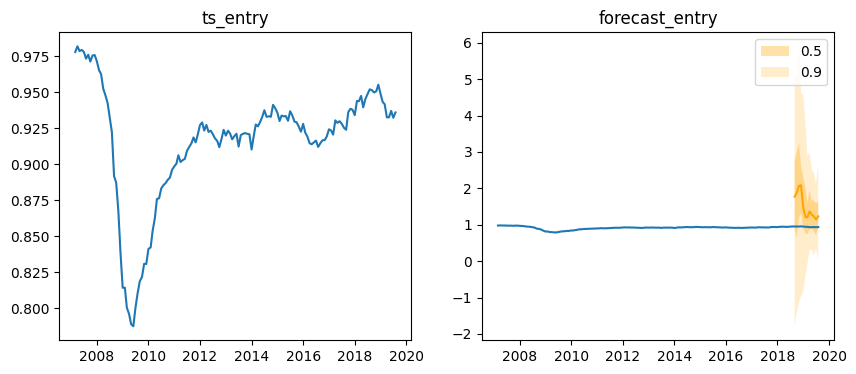

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.8897986 2.9437702 3.4864776 2.8329446 2.835255  2.5669966 2.473561
 2.521852  2.481625  2.4630575 2.4628332 2.4791799]
0.5-quantile (median) of the future window:
 [2.8498204 3.0519621 3.5263307 3.093255  2.954441  2.6134615 2.513311
 2.5567896 2.4854794 2.4742496 2.38776   2.4529595]


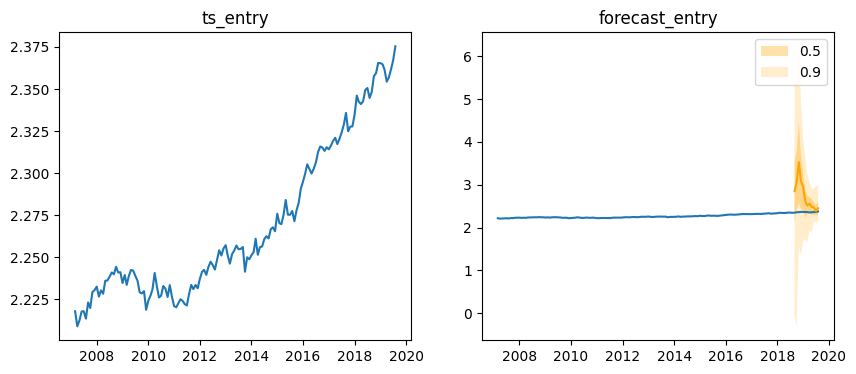

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.1538882 3.0856    3.8031461 3.1679428 2.903365  2.4614282 2.6035485
 2.519997  2.5511937 2.4956315 2.47064   2.4526563]
0.5-quantile (median) of the future window:
 [3.1026092 3.1630237 3.4355521 2.989714  2.7479014 2.5756044 2.5010386
 2.5156953 2.5117862 2.4968967 2.4641967 2.482553 ]


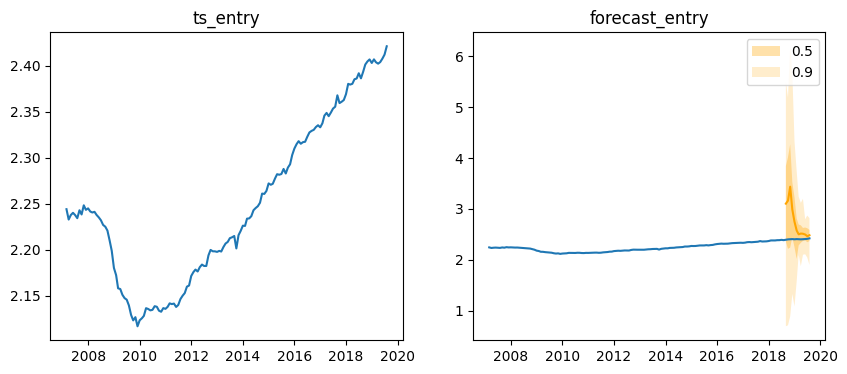

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.4271365  0.7794799  1.5102218  1.4491436  0.8435342  0.6176261
 0.66003525 0.51560605 0.45263714 0.41031593 0.57860065 0.70159996]
0.5-quantile (median) of the future window:
 [0.9370298  1.1504163  1.0410978  1.2396663  0.8521828  0.6003193
 0.5419344  0.34329176 0.319794   0.41235003 0.495974   0.60836303]


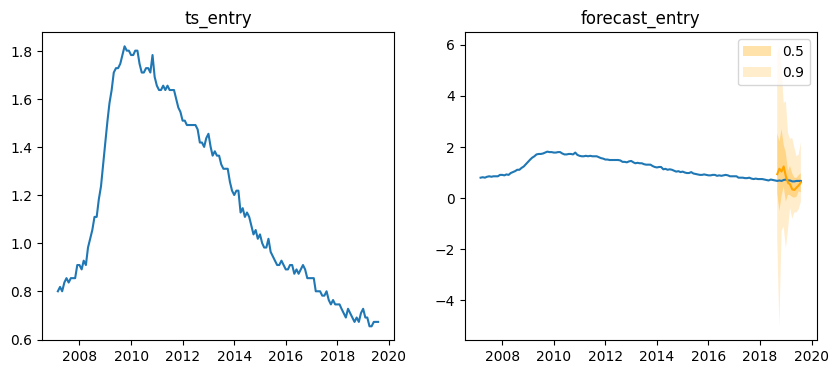

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.2614841 2.4446855 2.3656003 2.6271896 2.4228487 1.9052415 1.8173981
 1.704577  1.64966   1.7783668 1.6646763 1.7844468]
0.5-quantile (median) of the future window:
 [2.1698372 2.4828234 2.4877539 2.5301921 2.176046  1.8557309 1.7420471
 1.806672  1.6487916 1.7222314 1.6910752 1.820641 ]


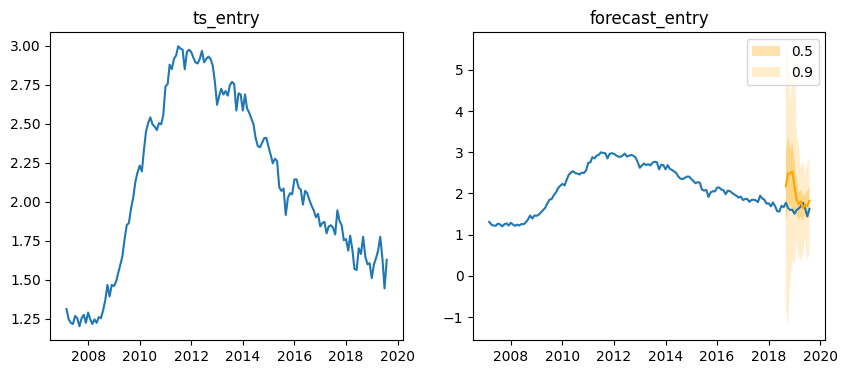

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.2647042 2.1885822 2.4969912 1.7474053 2.0149844 1.7790745 1.6888472
 1.4356188 1.5579422 1.5238099 1.4525642 1.6316342]
0.5-quantile (median) of the future window:
 [2.0834217 2.3004818 2.5198758 1.9725099 1.8892304 1.5700511 1.6315386
 1.3967013 1.6012592 1.4757404 1.4645227 1.6356746]


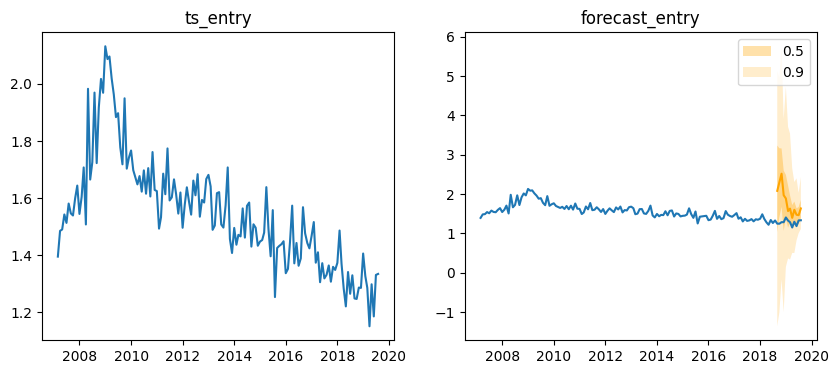

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.2906866 2.3905668 2.980797  2.7380373 2.3327868 1.9288934 1.6379111
 1.5380172 1.6824315 1.6338038 1.6534315 1.5364498]
0.5-quantile (median) of the future window:
 [2.0988572 2.341402  2.6716223 2.4390492 2.0915434 1.7896755 1.6929348
 1.6479746 1.590272  1.5832417 1.6231241 1.6195202]


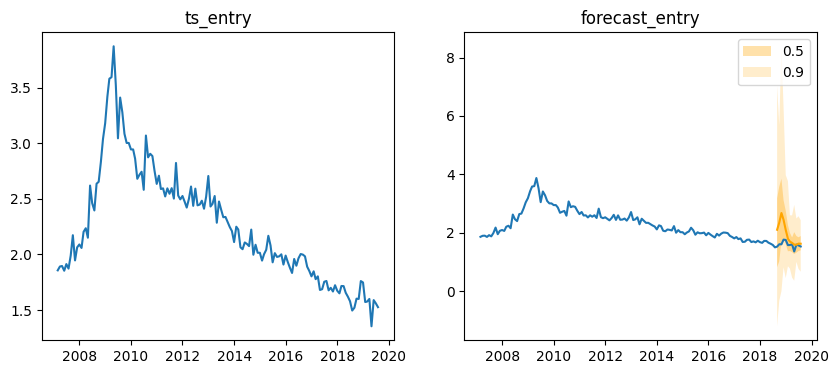

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.8657335 2.8983467 2.6209397 2.8203285 2.5649726 2.1812932 2.417306
 2.014081  2.1027267 1.9156058 2.0254412 1.9965788]
0.5-quantile (median) of the future window:
 [2.2548442 3.0787463 2.6964998 2.567706  2.587542  2.2275107 2.169518
 2.0524745 2.098795  1.9442205 2.024825  1.9161518]


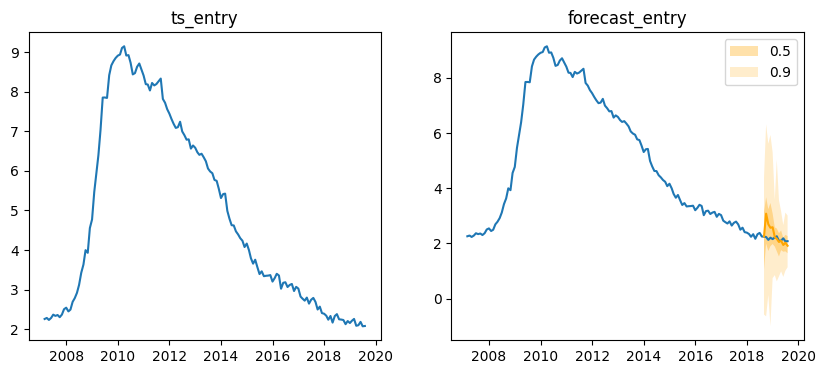

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.168298  3.0134168 3.0226438 2.254694  2.4725509 2.013949  2.0361626
 2.1109295 1.8138183 1.9610105 1.8348581 1.9430184]
0.5-quantile (median) of the future window:
 [2.1332223 2.325725  2.8535967 2.2979918 2.3450987 1.9908818 2.0000958
 1.9907331 1.8335023 1.9080074 1.7896587 1.8823907]


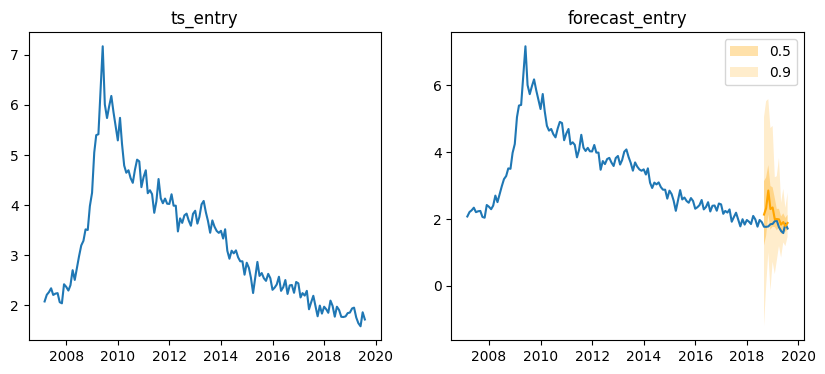

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.7782428 2.734505  2.8061807 2.7464902 2.7386696 2.3047976 2.3294966
 2.350704  2.23196   2.1562622 2.0402322 2.2431505]
0.5-quantile (median) of the future window:
 [2.3747404 2.5752263 2.8367438 2.7593353 2.750753  2.4805243 2.218984
 2.246093  2.1804976 2.1668184 2.0016277 2.2274218]


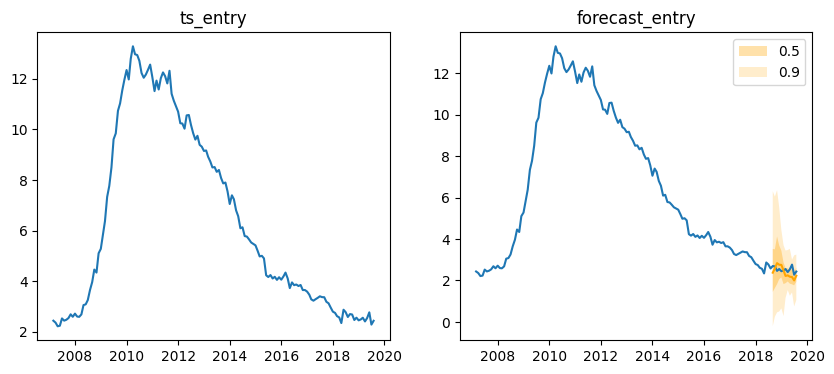

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.6627417  1.725556   1.6940978  1.5181782  1.4745996  1.2578111
 1.0555148  0.8158058  0.79727495 1.2117116  1.2566733  1.158714  ]
0.5-quantile (median) of the future window:
 [1.7995137  1.7698624  2.0337222  1.5926602  1.3984445  1.1020964
 1.0615965  0.8088876  0.88591886 0.98605466 1.0268048  1.1583283 ]


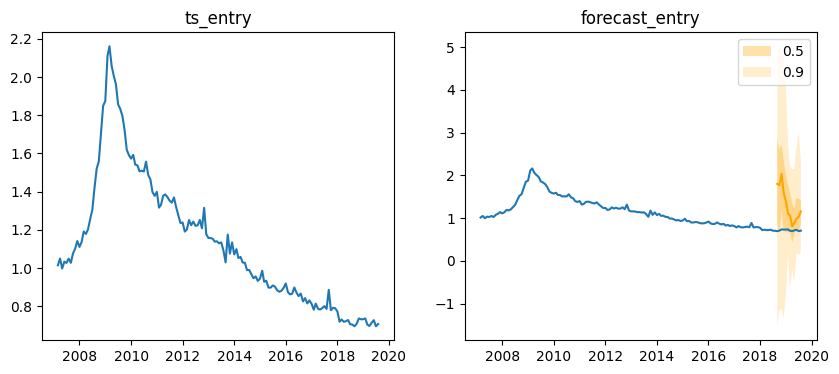

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.4090497 3.513996  3.9045029 3.3194797 3.2684567 2.799517  2.8404102
 2.8611524 2.8764646 2.8729227 2.8951235 2.8346407]
0.5-quantile (median) of the future window:
 [3.5190902 3.9214785 3.943359  3.237268  3.223985  2.835011  2.8232203
 2.873483  2.879484  2.8855135 2.8815498 2.843175 ]


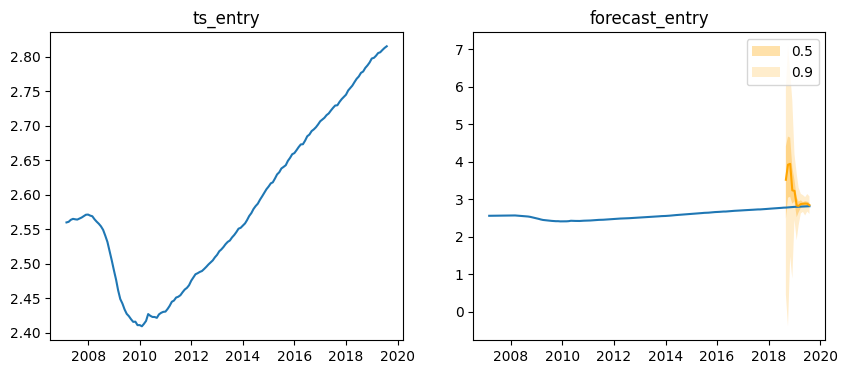

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.2853994 2.2443018 2.0972798 2.08734   1.6715894 1.495713  1.2688265
 1.2297679 1.2686896 1.3025726 1.2898304 1.3387978]
0.5-quantile (median) of the future window:
 [2.3772943 2.380615  2.3114166 1.9396154 1.5830556 1.4065456 1.1848524
 1.1760303 1.2435659 1.2158682 1.2528652 1.3264184]


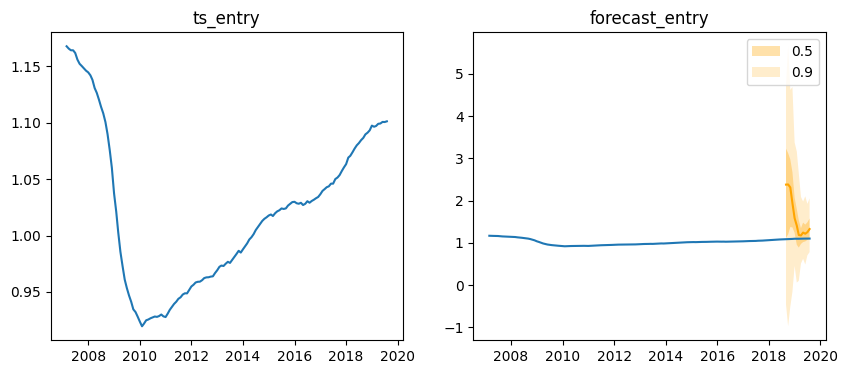

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.1893487 1.761405  1.7794816 1.7335356 1.8505011 1.2824528 1.3142533
 1.1834283 1.1352568 1.2121263 1.281948  1.4959162]
0.5-quantile (median) of the future window:
 [2.2835662 2.1242335 1.8895512 1.6663406 1.5665519 1.3311709 1.2871512
 1.1797041 1.1713284 1.2155843 1.2452228 1.4205928]


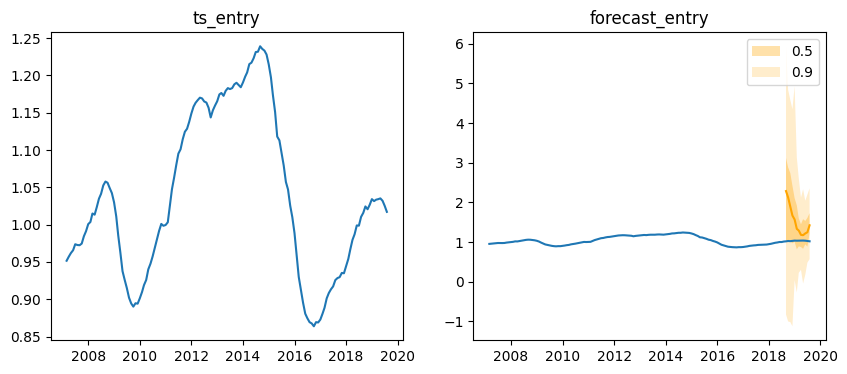

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.18901   3.1036217 3.697554  3.2578387 2.781594  2.6019943 2.634512
 2.5560114 2.5791538 2.5178099 2.5558453 2.5301957]
0.5-quantile (median) of the future window:
 [3.185603  3.489658  3.6542199 3.2434084 2.8109567 2.5406613 2.5801513
 2.527821  2.5626185 2.5466912 2.5388725 2.5222912]


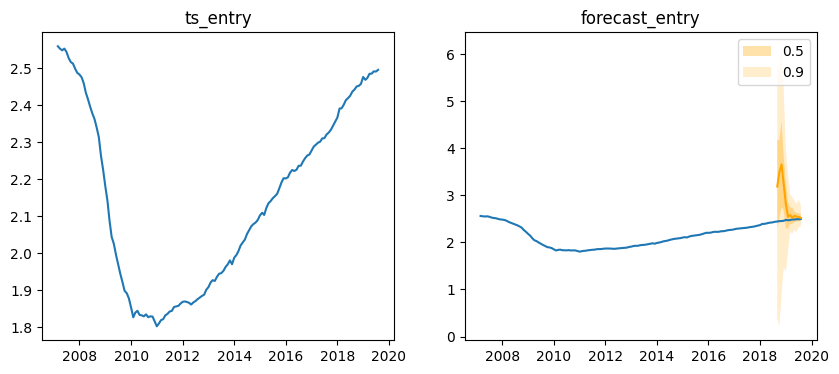

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.0606937 1.3230906 1.6779418 1.7626642 1.6790303 1.0130342 1.1725806
 1.0570326 1.0841112 1.053884  1.1740364 1.1339871]
0.5-quantile (median) of the future window:
 [1.9759979 1.9139298 1.7424228 1.6381671 1.5595953 1.0557725 1.1552774
 0.9914577 1.07819   1.0391643 1.1013213 1.0955069]


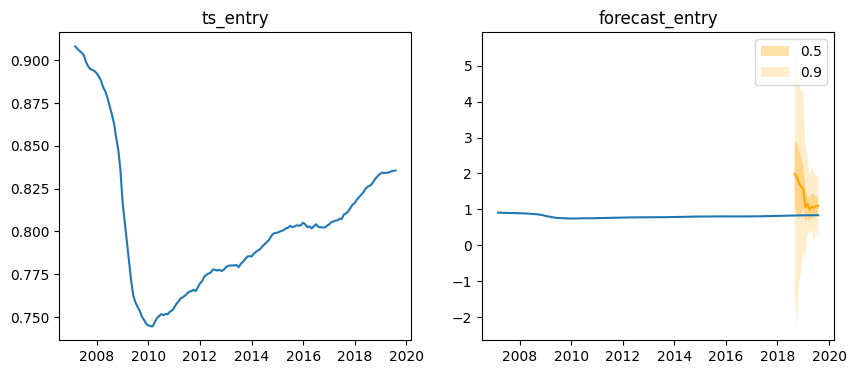

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.930001  1.876152  0.8082437 1.8904386 1.6986396 1.3114892 1.1224247
 1.2759668 1.2464869 1.2001796 1.1096361 1.2094766]
0.5-quantile (median) of the future window:
 [1.6458256 1.7447972 1.8924015 1.9092964 1.5009487 1.2582266 1.1042397
 1.1805687 1.1808348 1.2550553 1.1172456 1.21013  ]


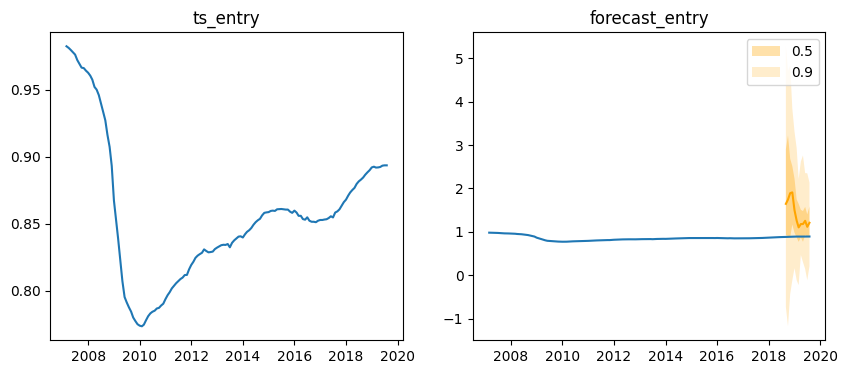

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.1950853 1.8459871 1.5149512 1.7712033 1.4483407 1.1377912 1.1033489
 1.091158  1.0564828 1.0642112 1.0764794 1.1937599]
0.5-quantile (median) of the future window:
 [2.0046859  2.1593444  1.4928846  1.6720885  1.3331901  1.1640316
 1.0758605  1.0530884  0.92927366 1.1120062  1.0588369  1.2172487 ]


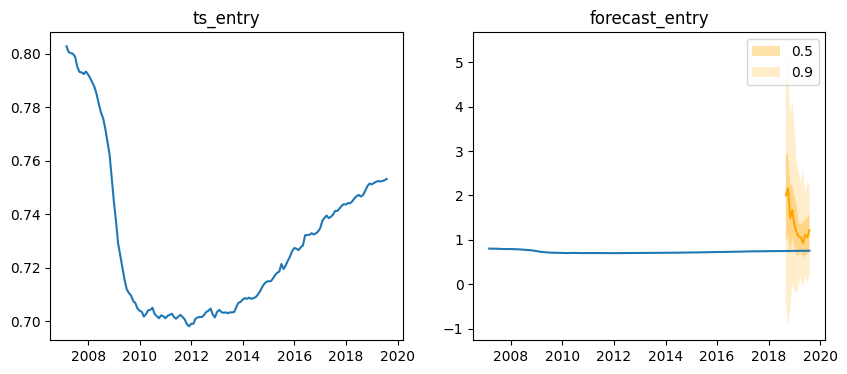

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [4.301371  4.7092757 4.779815  4.3863244 3.8441708 3.785036  3.8168147
 3.8525815 3.8622892 3.8617704 3.8189988 3.832674 ]
0.5-quantile (median) of the future window:
 [4.273709  4.9175844 4.850759  4.244764  3.9301949 3.781237  3.7642033
 3.8370514 3.8672996 3.868342  3.829419  3.8408983]


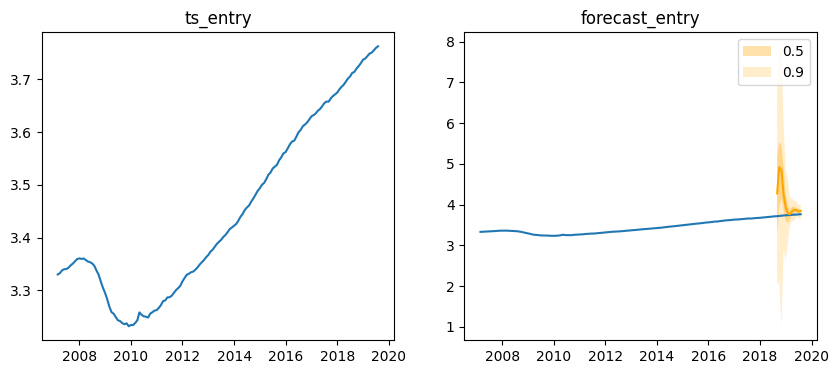

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.215794  3.3858645 4.256772  3.267319  2.9276865 2.5316327 2.5767012
 2.5339015 2.59462   2.5884836 2.5593412 2.5224073]
0.5-quantile (median) of the future window:
 [3.4958181 3.4991038 4.0373116 3.309321  2.9598465 2.5180678 2.5692086
 2.5098538 2.590524  2.5901997 2.5649617 2.5495324]


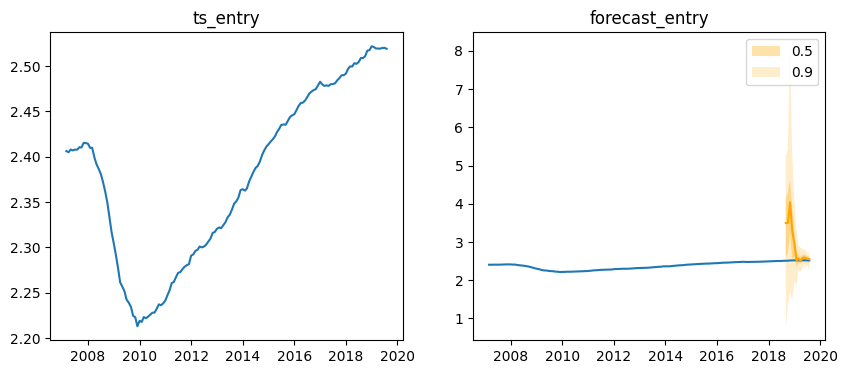

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.8052523 3.657752  2.9712248 3.4039917 2.5468316 2.4528098 2.2341657
 2.3175352 2.2834673 2.3121815 2.292231  2.2671747]
0.5-quantile (median) of the future window:
 [2.9274688 3.4218466 3.339128  3.176547  2.5170834 2.3496327 2.2348497
 2.2807047 2.2636964 2.2959447 2.2558334 2.261465 ]


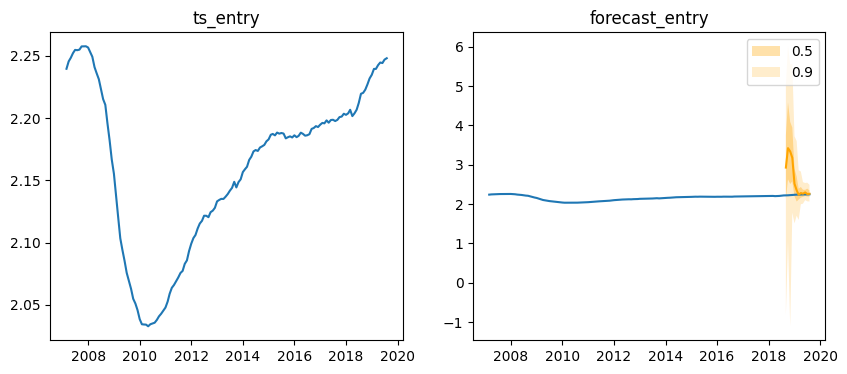

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.1217487 4.3396807 3.9001894 3.679694  3.163272  3.010158  2.9521813
 2.9605954 2.9934745 2.915319  2.9633145 2.9278448]
0.5-quantile (median) of the future window:
 [3.469548  4.135256  3.90834   3.5052834 3.2435462 2.959836  2.9179606
 2.927452  2.9710612 2.9372056 2.9623868 2.9187114]


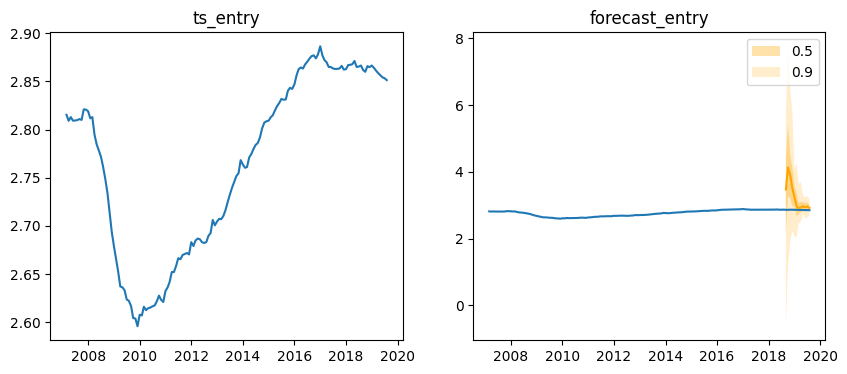

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.9965384 4.5203657 4.755922  4.1779118 3.6796143 3.3704727 3.483137
 3.528184  3.5445433 3.5372999 3.5152454 3.5078263]
0.5-quantile (median) of the future window:
 [4.230646  4.32866   4.383187  4.159992  3.5910134 3.4274626 3.5529308
 3.5685546 3.5507777 3.4965737 3.5128486 3.4955661]


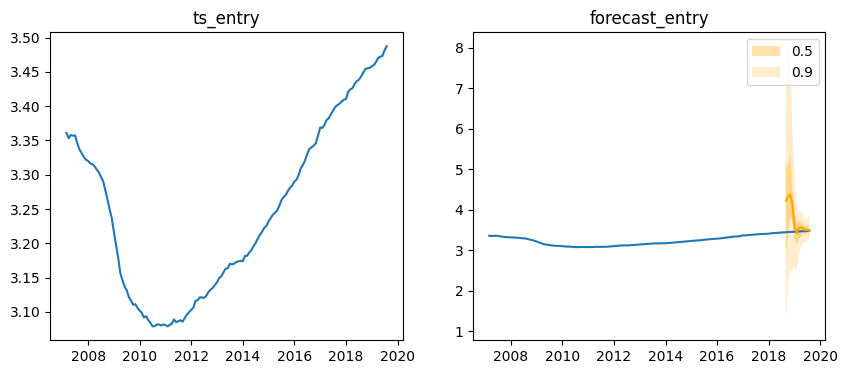

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [3.5804117 3.4238927 3.511567  3.2722013 3.1511626 2.7386618 2.8965392
 2.8008065 2.8093545 2.7875419 2.6738672 2.7437289]
0.5-quantile (median) of the future window:
 [3.4170973 3.5484018 3.6183877 3.1758044 3.0750914 2.7619314 2.8438947
 2.7748609 2.8294268 2.7939165 2.7397323 2.731767 ]


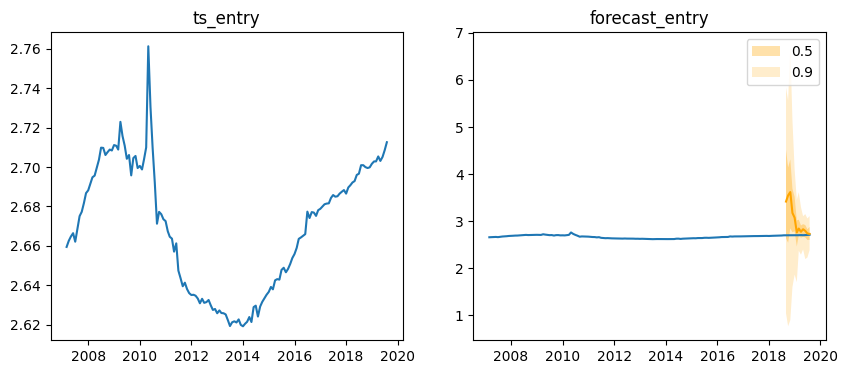

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.066933  1.8153245 2.0188124 1.7804788 1.7055006 1.6074046 1.5301638
 1.4837291 1.391938  1.2488351 1.35727   1.5168052]
0.5-quantile (median) of the future window:
 [1.9701185 1.9399666 2.010817  1.5186496 1.721061  1.5742362 1.4177144
 1.4118226 1.3886399 1.1761366 1.2097776 1.4089321]


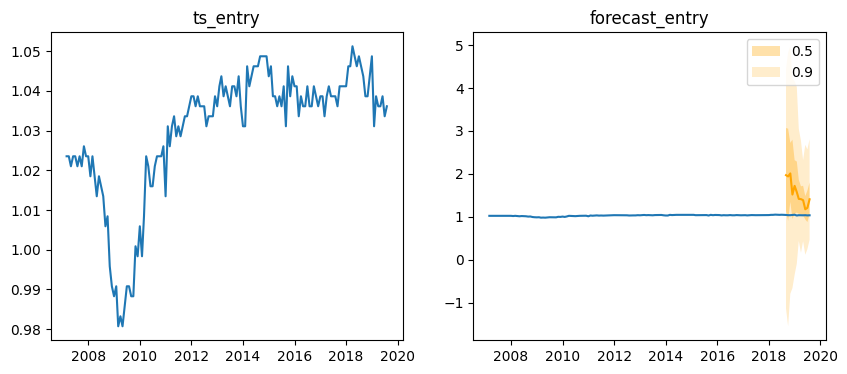

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.1772747 2.533832  2.65997   2.4931235 1.9855173 2.1208744 2.003491
 2.0113864 1.8052809 1.8040962 1.7561914 1.7867665]
0.5-quantile (median) of the future window:
 [2.3596613 2.7600658 2.7476714 2.5779867 2.1382806 2.014518  1.8817562
 1.9636483 1.8823017 1.7947257 1.8009316 1.8279798]


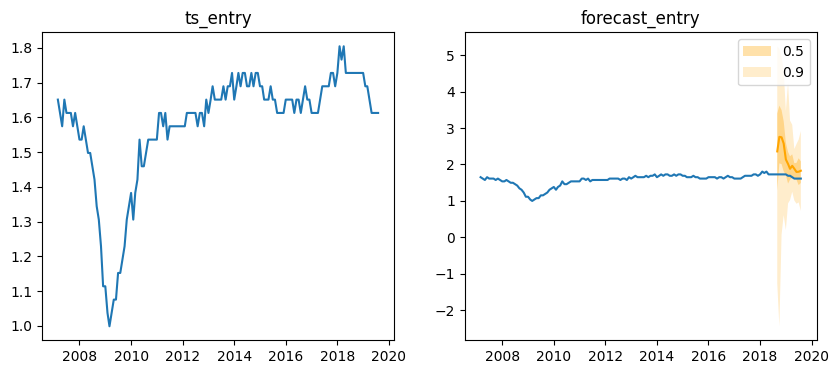

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.3191123 1.9531413 1.924439  1.7171284 1.6476312 1.2653723 1.4193063
 1.5625392 1.2889458 1.4783891 1.2765871 1.3718185]
0.5-quantile (median) of the future window:
 [2.0585194 2.1199527 1.7971435 1.9129353 1.585635  1.5618681 1.4693364
 1.3907715 1.2175201 1.3313842 1.2748041 1.4031918]


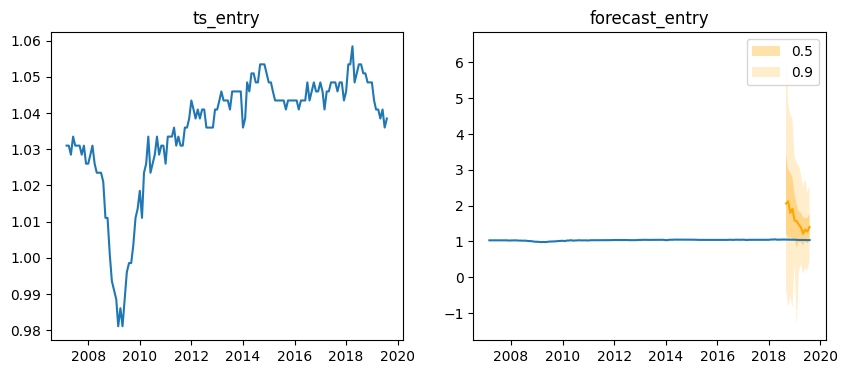

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.7884549 1.982803  1.9337149 2.1036124 1.5250455 1.4476349 0.9937002
 1.1896372 1.3035142 1.2627456 1.2755796 1.0199963]
0.5-quantile (median) of the future window:
 [1.9419433 1.9960043 2.1768272 2.0473378 1.5320723 1.3472987 1.1282322
 1.0965505 1.1762111 1.1975698 1.1694324 1.0389514]


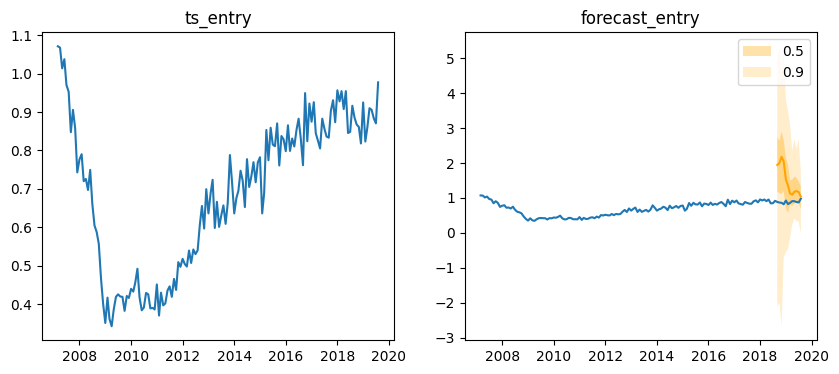

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.6706558  1.8506534  1.8339934  1.6209265  1.1638649  1.0609783
 0.7614866  0.71351004 0.8502653  0.5772812  0.67624927 0.8708908 ]
0.5-quantile (median) of the future window:
 [1.919285   1.6630303  1.6852236  1.6490939  1.0340252  0.8059569
 0.6020997  0.61686397 0.71049917 0.6183933  0.68687326 0.86915153]


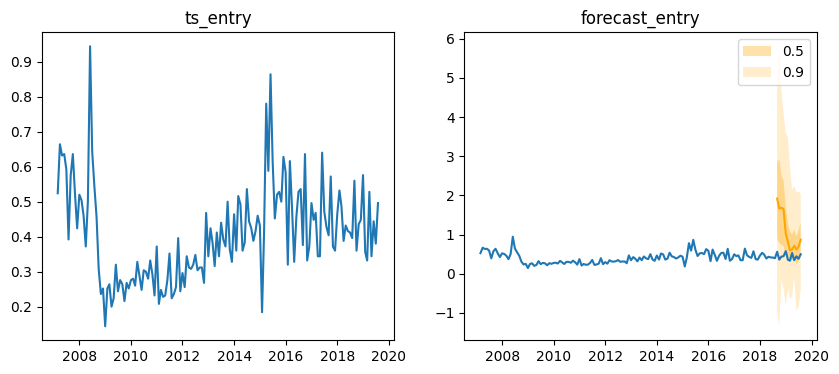

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.4230645  1.7031417  1.4910538  1.3010552  1.3402065  0.88927704
 1.3931366  1.2978009  1.0500312  1.1545208  0.9422144  1.1612597 ]
0.5-quantile (median) of the future window:
 [1.6117334  1.7202625  1.6784632  1.2549136  1.3464997  1.0035422
 1.1262437  0.93066305 0.9362693  1.0872612  0.95832497 1.1013068 ]


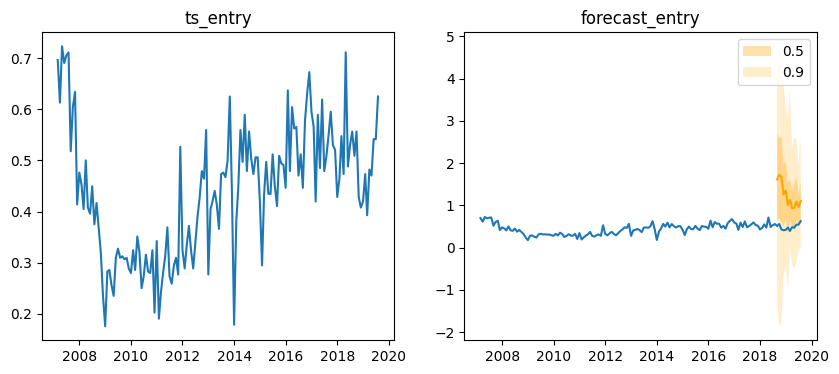

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [2.1416998 1.7238847 2.857911  2.0263565 2.130835  1.6179501 2.0122156
 1.4450316 1.5164397 1.4750267 1.446875  1.4637402]
0.5-quantile (median) of the future window:
 [2.0783334 2.1611829 2.6886911 2.077658  1.9746894 1.6356127 1.4772213
 1.4515653 1.4962281 1.4594252 1.4439992 1.4885218]


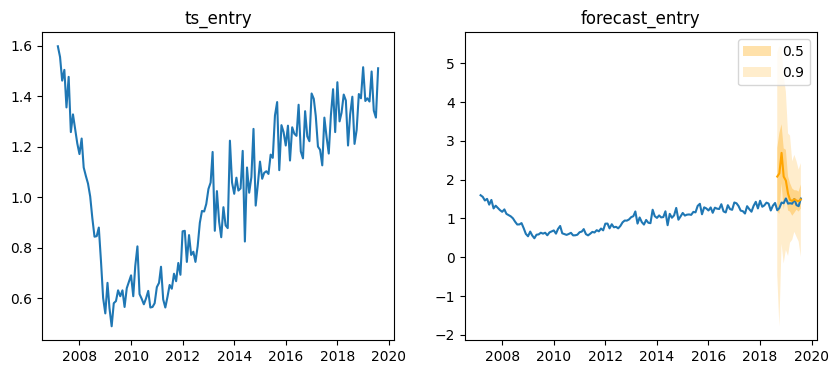

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [1.5466859 2.0571015 1.82366   2.028762  1.8026832 1.4618973 1.3035719
 1.0871825 1.2203268 1.0408133 1.1604009 1.2981617]
0.5-quantile (median) of the future window:
 [1.6028246 2.0839407 1.9544345 1.8937356 1.76771   1.4501486 1.3370922
 1.1067744 1.0566862 0.9912529 1.0933701 1.3279176]


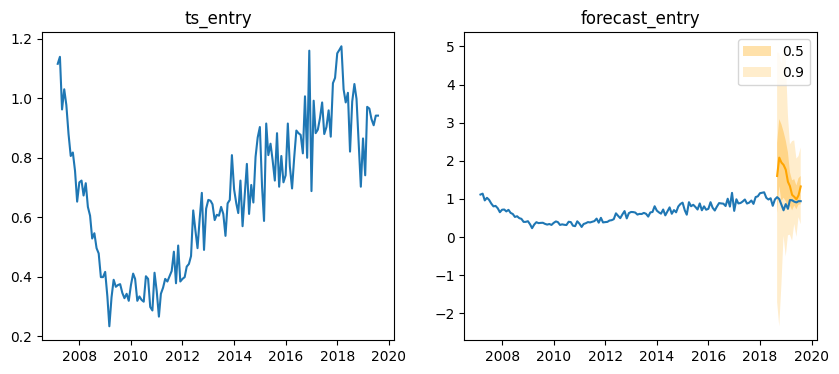

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2018-09
Frequency of the time series: <MonthEnd>
Mean of the future window:
 [16.684698 17.152052 17.449419 17.649515 17.49474  17.124716 17.387321
 17.218945 17.463783 17.804747 17.560873 17.395378]
0.5-quantile (median) of the future window:
 [16.93871  16.987354 17.879065 17.471537 17.613087 17.393284 17.345194
 17.328432 17.473986 17.59752  17.636421 17.328564]


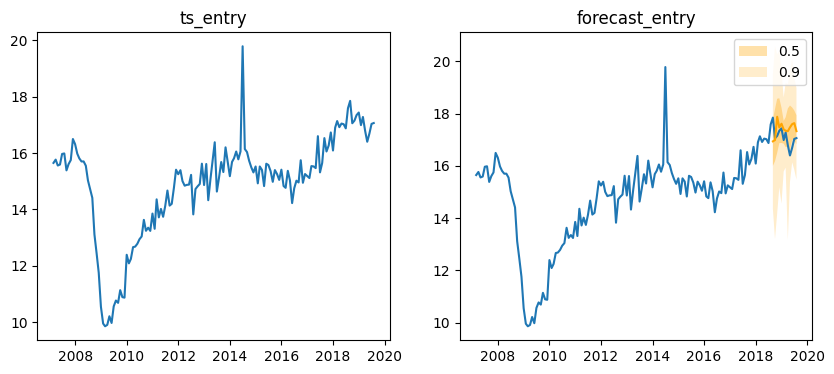

In [ ]:
for ts_index in range(min(50, len(test_dataset))):
    ts_entry = tss[ts_index]
    dataset_test_entry = test_dataset[ts_index]
    forecast_entry = forecasts[ts_index]
    
    print(f"Number of sample paths: {forecast_entry.num_samples}")
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

    print(f"Mean of the future window:\n {forecast_entry.mean}")
    print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) 

    axs[0].plot(ts_entry[-150:].to_timestamp()) 
    axs[0].set_title('ts_entry')

    axs[1].plot(ts_entry[-150:].to_timestamp())  
    forecast_entry.plot(show_label=True, color="orange", ax=axs[1]) 
    axs[1].set_title('forecast_entry')
    axs[1].legend()
    
    plt.show()